# Generative score-based diffusion

In this example we train a [score-based diffusion](https://arxiv.org/abs/2011.13456) as a generative model for MNIST digits.

![samples](../imgs/score_based_diffusion_samples.png)

This example:

- Uses the variance-preserving SDE to corrupt the data:

$y(0) \sim \mathrm{data}\qquad\mathrm{d}y(t) = -\frac{1}{2} β(t)y(t)\mathrm{d}t + \sqrt{β(t)}\mathrm{d}w(t) \qquad\text{for }t \in [0, T].$

- Trains a score model $s_\theta$ according to the denoising objective:

$\arg\min_\theta \mathbb{E}_{t \sim \mathrm{Uniform}[0, T]}\mathbb{E}_{y(0) \sim \mathrm{data}}\mathbb{E}_{(y(t)|y(0)) \sim \mathrm{SDE}} \lambda(t) \| s_\theta(t, y(t)) - \nabla_y \log p(y(t)|y(0)) \|_2^2$

- Uses the equivalent ODE for sampling (solved using the [Diffrax](https://github.com/patrick-kidger/diffrax) library):

$y(1) \sim \mathcal{N}(0, I)\qquad\mathrm{d}y(t) = -\frac{1}{2}β(t) (y(t) + s_\theta(t, y(t)))\mathrm{d}t \qquad\text{for }t \in [0, T].$

- Uses an [MLP-Mixer](https://arxiv.org/abs/2105.01601) to parameterise the score model $s_\theta$.


!!! warning

    This example will take a short while to run on a GPU.

!!! cite "Reference"

    [arXiv link](https://arxiv.org/abs/2011.13456)

    ```bibtex
    @inproceedings{song2021scorebased,
    title={Score-Based Generative Modeling through Stochastic Differential
           Equations},
    author={Yang Song and Jascha Sohl-Dickstein and Diederik P Kingma and
            Abhishek Kumar and Stefano Ermon and Ben Poole},
    booktitle={International Conference on Learning Representations},
    year={2021},
    }
    ```

In [1]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from unet import UNet2DModel

import equinox as eqx


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

First let's specify our score-based model $s_\theta$, as an MLP-Mixer. We'll use many of the pre-built `equinox.nn` layers here.

We encode time-dependence in a simple way, by just concatenating it as another channel.

In [2]:
class MixerBlock(eqx.Module):
    patch_mixer: eqx.nn.MLP
    hidden_mixer: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self, num_patches, hidden_size, mix_patch_size, mix_hidden_size, *, key
    ):
        tkey, ckey = jr.split(key, 2)
        self.patch_mixer = eqx.nn.MLP(
            num_patches, num_patches, mix_patch_size, depth=1, key=tkey
        )
        self.hidden_mixer = eqx.nn.MLP(
            hidden_size, hidden_size, mix_hidden_size, depth=1, key=ckey
        )
        self.norm1 = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.norm2 = eqx.nn.LayerNorm((num_patches, hidden_size))

    def __call__(self, y):
        y = y + jax.vmap(self.patch_mixer)(self.norm1(y))
        y = einops.rearrange(y, "c p -> p c")
        y = y + jax.vmap(self.hidden_mixer)(self.norm2(y))
        y = einops.rearrange(y, "p c -> c p")
        return y


class Mixer2d(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.ConvTranspose2d
    blocks: list
    norm: eqx.nn.LayerNorm
    t1: float

    def __init__(
        self,
        img_size,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        *,
        key,
    ):
        input_size, height, width = img_size
        assert (height % patch_size) == 0
        assert (width % patch_size) == 0
        num_patches = (height // patch_size) * (width // patch_size)
        inkey, outkey, *bkeys = jr.split(key, 2 + num_blocks)

        self.conv_in = eqx.nn.Conv2d(
            input_size + 1, hidden_size, patch_size, stride=patch_size, key=inkey
        )
        self.conv_out = eqx.nn.ConvTranspose2d(
            hidden_size, input_size, patch_size, stride=patch_size, key=outkey
        )
        self.blocks = [
            MixerBlock(
                num_patches, hidden_size, mix_patch_size, mix_hidden_size, key=bkey
            )
            for bkey in bkeys
        ]
        self.norm = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.t1 = t1

    def __call__(self, t, y):
        t = t / self.t1
        _, height, width = y.shape
        t = einops.repeat(t, "-> 1 h w", h=height, w=width)
        y = jnp.concatenate([y, t])
        y = self.conv_in(y)
        _, patch_height, patch_width = y.shape
        y = einops.rearrange(y, "c h w -> c (h w)")
        for block in self.blocks:
            y = block(y)
        y = self.norm(y)
        y = einops.rearrange(y, "c (h w) -> c h w", h=patch_height, w=patch_width)
        return self.conv_out(y)

Now set up our loss and sampling functions. Note that the variance-preserving SDE is parameterised by some function $β$. The value $\nabla_y \log p(y(t)|y(0))$ is computed analytically, in which $\int_0^t β(s) \mathrm{d}s$ appears.

As such our functions are parameterised by a function `int_beta`, and where necessary we obtain $β$ through autodifferentiation.

In [3]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))


@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

Now get the data, i.e. the MNIST dataset.

In [4]:
def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

In [5]:
def plot_backward(
    epoch, generate_fn, data_min, data_max, data_mean, data_std, sample_size=10, *, key
):
    sample_key = jr.split(key, sample_size**2)
    generated = generate_fn(sample_key)
    generated = data_mean + data_std * generated
    sample = jnp.clip(generated, data_min, data_max)
    sample = einops.rearrange(
        generated,
        "(n1 n2) 1 h w -> (n1 h) (n2 w)",
        n1=sample_size,
        n2=sample_size,
    )

    plt.imshow(sample, cmap="Greys")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

And now we have the main training loop.

In [6]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state


def main(
    # Model hyperparameters
    block_out_channels=(8, 8, 16),
    norm_groups=8,
    layers_per_block=2,
    attn_head_dim=4,
    time_embedding_dim=16,
    max_period=20.0,  # unlike discrete models, T is small in continuous model
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=100_000,
    lr=3e-4,
    batch_size=256,
    print_every=1_000,
    plot_every=10_000,
    # Sampling hyperparameters
    dt0=0.1,
    sample_size=10,
    # Seed
    seed=5678,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, loader_key, sample_key = jr.split(key, 4)
    data = mnist()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = UNet2DModel(
        in_channels=data_shape[0],
        out_channels=data_shape[0],
        block_out_channels=block_out_channels,
        norm_groups=norm_groups,
        max_period=max_period,
        key=model_key,
    )

    int_beta = lambda t: t  # Try experimenting with other options here!
    weight = lambda t: 1 - jnp.exp(
        -int_beta(t)
    )  # Just chosen to upweight the region near t=0.

    opt = optax.adabelief(lr)
    # Optax will update the floating-point JAX arrays in the model.
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    total_value = 0
    total_size = 0
    for step, data in zip(
        range(num_steps), dataloader(data, batch_size, key=loader_key)
    ):
        value, model, train_key, opt_state = make_step(
            model, weight, int_beta, data, t1, train_key, opt_state, opt.update
        )
        total_value += value.item()
        total_size += 1
        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0
        if (step % plot_every) == 0 or step == num_steps - 1:
            print("Generated samples")
            sample_fn = jax.vmap(
                ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
            )
            plot_backward(
                epoch=step,
                generate_fn=sample_fn,
                data_min=data_min,
                data_max=data_max,
                data_std=data_std,
                data_mean=data_min,
                sample_size=sample_size,
                key=sample_key,
            )

Step=0 Loss=1.0171715021133423
Generated samples


/home/anhth/anaconda3/lib/python3.9/site-packages/diffrax/integrate.py:83: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  [ts, save_index] + jax.tree_leaves(ys),
/home/anhth/anaconda3/lib/python3.9/site-packages/diffrax/integrate.py:81: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  lambda s: [s.ts, s.save_index] + jax.tree_leaves(s.ys),


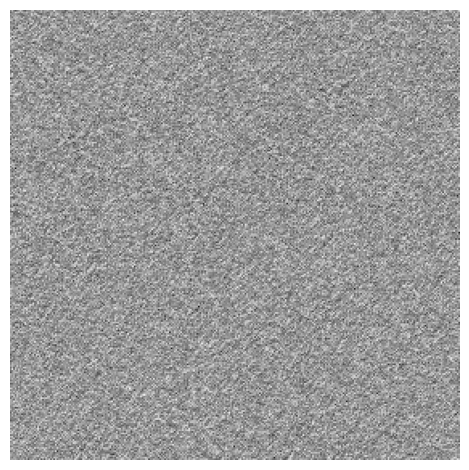

Step=1000 Loss=0.05723008833453059
Step=2000 Loss=0.023068355202674865
Step=3000 Loss=0.0197355531193316
Step=4000 Loss=0.018298981869593264
Step=5000 Loss=0.017576369087211788
Step=6000 Loss=0.017081583213061094
Step=7000 Loss=0.016689803836867214
Step=8000 Loss=0.016432122520171105
Step=9000 Loss=0.016227061280980705
Step=10000 Loss=0.016004113183356823
Generated samples


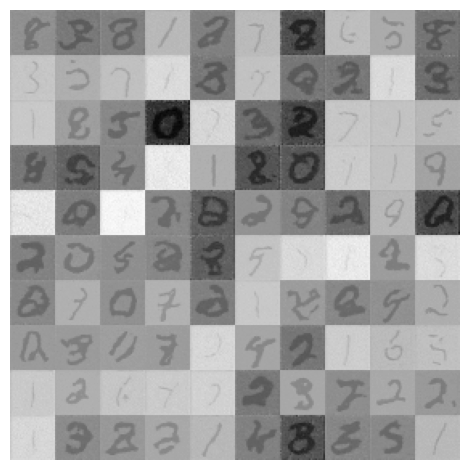

Step=11000 Loss=0.015798614874482156
Step=12000 Loss=0.015697374688461423
Step=13000 Loss=0.015570372603833675
Step=14000 Loss=0.015396066348068416
Step=15000 Loss=0.015356894485652446
Step=16000 Loss=0.01519224965479225
Step=17000 Loss=0.01485900773946196
Step=18000 Loss=0.01470031099859625
Step=19000 Loss=0.014536345847882331
Step=20000 Loss=0.014410698073916137
Generated samples


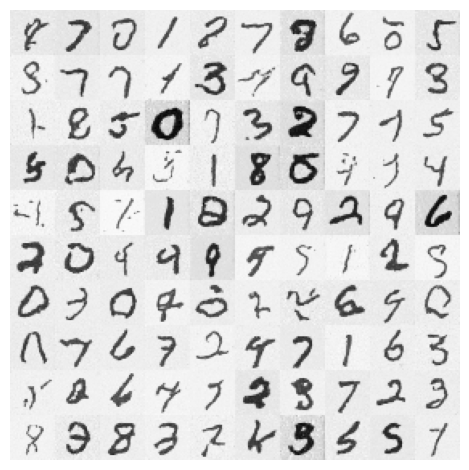

Step=21000 Loss=0.01425336057227105
Step=22000 Loss=0.014177291121333837
Step=23000 Loss=0.014099204754456878
Step=24000 Loss=0.014044398780912161
Step=25000 Loss=0.013978009899146856
Step=26000 Loss=0.013978368585929275
Step=27000 Loss=0.013860925088636577
Step=28000 Loss=0.0138276062970981
Step=29000 Loss=0.01380750650446862
Step=30000 Loss=0.013760099965147675
Generated samples


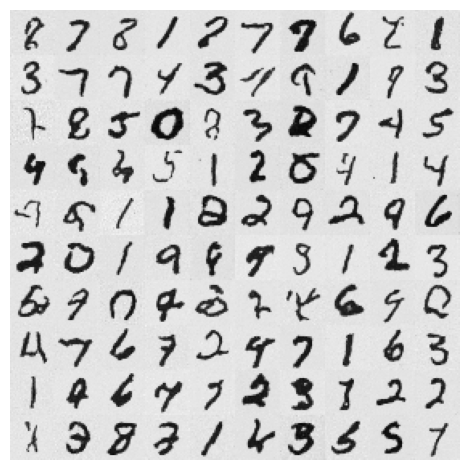

Step=31000 Loss=0.013743917810730637
Step=32000 Loss=0.013673788500018418
Step=33000 Loss=0.013636179371736943
Step=34000 Loss=0.013617144299671053
Step=35000 Loss=0.01358369305729866
Step=36000 Loss=0.013533315563574433
Step=37000 Loss=0.013485822428017855
Step=38000 Loss=0.013481736066751182
Step=39000 Loss=0.013505558871664106
Step=40000 Loss=0.013467064341530204
Generated samples


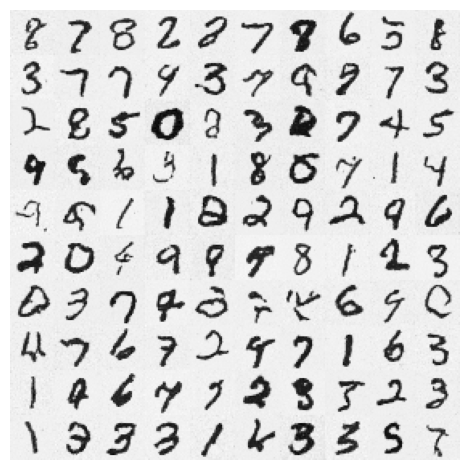

Step=41000 Loss=0.013432332645170391
Step=42000 Loss=0.013405876692384482
Step=43000 Loss=0.013406236336566507
Step=44000 Loss=0.013363730330951512
Step=45000 Loss=0.013307509923353791
Step=46000 Loss=0.013320933686569333
Step=47000 Loss=0.013286161632277072
Step=48000 Loss=0.013305697505362332
Step=49000 Loss=0.013240749425254762
Step=50000 Loss=0.013260260294191539
Generated samples


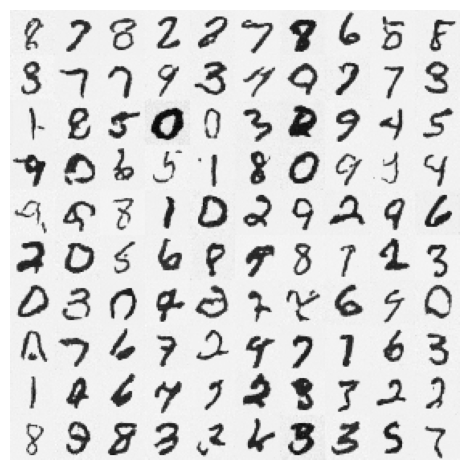

Step=51000 Loss=0.013251910334452987
Step=52000 Loss=0.01322592862509191
Step=53000 Loss=0.013188613607548177
Step=54000 Loss=0.013207653362303973
Step=55000 Loss=0.013195316308178008
Step=56000 Loss=0.013175787698477506
Step=57000 Loss=0.013150721047073603
Step=58000 Loss=0.013138813527300954
Step=59000 Loss=0.013093222349882127
Step=60000 Loss=0.013035377494059502
Generated samples


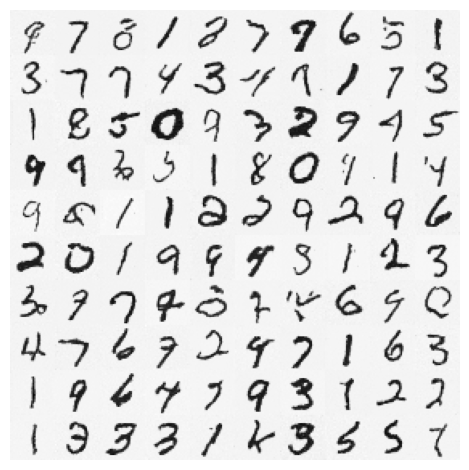

Step=61000 Loss=0.013116938404738904
Step=62000 Loss=0.013071100343950093
Step=63000 Loss=0.013067248399369418
Step=64000 Loss=0.013080253493040801
Step=65000 Loss=0.0130475905360654
Step=66000 Loss=0.013059903417713941
Step=67000 Loss=0.013010707341134548
Step=68000 Loss=0.012996505247429013
Step=69000 Loss=0.012971564636565744
Step=70000 Loss=0.01305215451773256
Generated samples


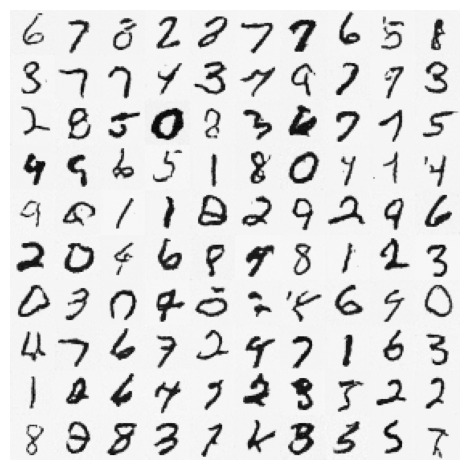

Step=71000 Loss=0.01297907490003854
Step=72000 Loss=0.01293533133994788
Step=73000 Loss=0.012971647018566727
Step=74000 Loss=0.012936072790063917
Step=75000 Loss=0.0129511921973899
Step=76000 Loss=0.01296850074082613
Step=77000 Loss=0.012938450273126364
Step=78000 Loss=0.01294087703898549
Step=79000 Loss=0.01292604417540133
Step=80000 Loss=0.012895663020201027
Generated samples


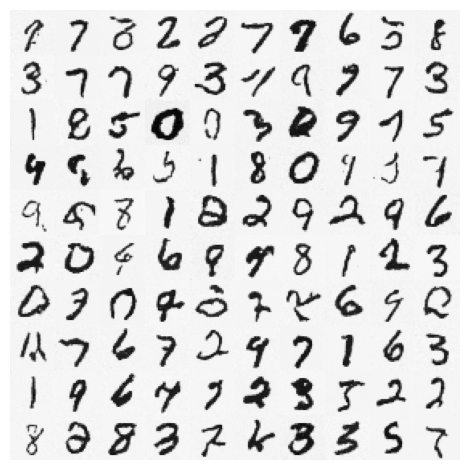

Step=81000 Loss=0.01292815004196018
Step=82000 Loss=0.012910231774672865
Step=83000 Loss=0.012860320794396102
Step=84000 Loss=0.012871695075184106
Step=85000 Loss=0.012869950884953142
Step=86000 Loss=0.0128560433909297
Step=87000 Loss=0.012854356283321976
Step=88000 Loss=0.012873318932950496
Step=89000 Loss=0.012859086076729
Step=90000 Loss=0.012825991191901266
Generated samples


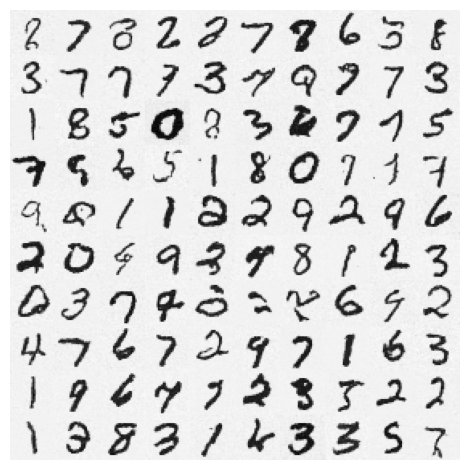

Step=91000 Loss=0.01284978981409222
Step=92000 Loss=0.012826002675108611
Step=93000 Loss=0.01284896782040596
Step=94000 Loss=0.012847747357562184
Step=95000 Loss=0.01284916501492262
Step=96000 Loss=0.012795610728673638
Step=97000 Loss=0.012787545068189502
Step=98000 Loss=0.01276433908008039
Step=99000 Loss=0.012756290868856013
Step=99999 Loss=0.012788718308063897
Generated samples


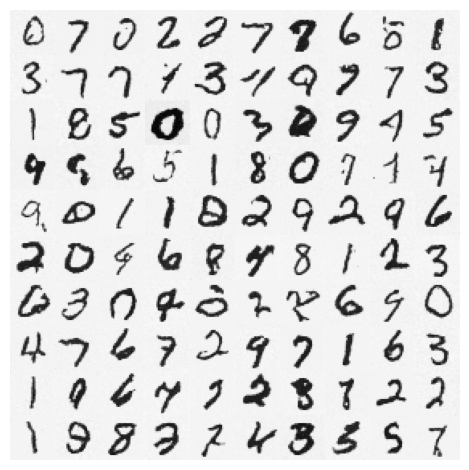

In [7]:
main()